In [1]:
import shnitsel as sh
import shnitsel.xarray

import os

In [2]:
A01 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C2H4.nc')
I01 = sh.open_frames('/nc/SHNITSEL_databases/dynamic/I01_ch2nh2_dynamic.nc')
A02 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C3H6.nc')
A03 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C4H8_g0.nc')

## Complete workflow for all ensembles

In [4]:
limits = dict(CC=2, HC=2, CN=2, HN=2)
cpnds = {'I01': I01, 'A01': A01, 'A02': A02, 'A03': A03}
lengths = {}
cutoffs = {}
masks = {}
filtered = {}
truncated = {}
for c in cpnds:
    lengths[c] = cpnds[c].atXYZ.sh.get_bond_lengths()
    masks[c] = lengths[c] < lengths[c].sh.msel(**limits)
    
    # Filter out trajectories with cleavages:
    stayed_intact = masks[c].all('bond').groupby('trajid').all()
    filtered[c] = cpnds[c].sh.sel_trajs(stayed_intact)
    if not os.path.isfile(f'/tmp/{c}_filtered.nc'):
        filtered[c].sh.save_frames(f'/tmp/{c}_filtered.nc')

    # Truncate trajectories after cleavages:
    cutoffs[c] = masks[c].sh.last_time_where()
    earliest = cutoffs[c].min('bond')
    truncated[c] = cpnds[c].sh.truncate(earliest)
    if not os.path.isfile(f'/tmp/{c}_truncated.nc'):
        truncated[c].sh.save_frames(f'/tmp/{c}_truncated.nc')
    
    cutoffs[c]['original'] = lengths[c].time.groupby('trajid').last()
    cutoffs[c]['earliest'] = cutoffs[c].min('bond')

## Step-by-step walkthrough for A03 (butene)

We could specify bonds by atom indices, but normally it should be fine to let RDKit find the bonds behind the scenes:

In [24]:
bl = A03.atXYZ.sh.get_bond_lengths()
bl

<xarray.DataArray (frame: 36579, bond: 11)> Size: 3MB
array([[1.49591591, 1.38201021, 1.54326204, ..., 0.99126882, 1.09715759,
        1.07634289],
       [1.4969744 , 1.37620096, 1.53729226, ..., 1.02146957, 1.08917098,
        1.0555919 ],
       [1.49601842, 1.37228996, 1.5300623 , ..., 1.06015935, 1.08329782,
        1.03878779],
       ...,
       [1.63342424, 1.39987539, 1.58987745, ..., 1.04497093, 1.10881704,
        1.0977842 ],
       [1.64030952, 1.38990291, 1.59416328, ..., 1.03910831, 1.12213558,
        1.08766457],
       [1.64714128, 1.38023807, 1.59909496, ..., 1.04076466, 1.13326708,
        1.07824624]], shape=(36579, 11))
Coordinates:
  * frame      (frame) object 293kB MultiIndex
  * trajid     (frame) int64 293kB 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time       (frame) float64 293kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
  * bond       (bond) object 88B MultiIndex
  * bond_type  (bond) object 88B 'CC' 'CC' 'CC' 'HC' ... 'HC' 'HC' 'HC' 'HC'
  * atom1      (bond) int64 88B 0 1 2 0 0 0 1 2 3 3 3
  * atom2      (bond) int64 88B 1 2 3 4 5 6 7 8 9 10 11

In [25]:
bl.sel(time=0, atom1=0, atom2=1)

<xarray.DataArray (trajid: 156, bond_type: 1)> Size: 1kB
array([[1.49591591],
       [1.50173887],
       [1.52578064],
       [1.54461901],
       [1.52619742],
       [1.57780078],
       [1.53297867],
       [1.53772785],
       [1.51137434],
       [1.49337182],
       [1.47774602],
       [1.42293157],
       [1.49099308],
       [1.50932587],
       [1.51752186],
       [1.56050254],
       [1.46944866],
       [1.42530199],
       [1.47907674],
       [1.53836055],
...
       [1.48967433],
       [1.50706037],
       [1.5385642 ],
       [1.49242971],
       [1.49009918],
       [1.54104382],
       [1.53069804],
       [1.53781265],
       [1.50309383],
       [1.47835256],
       [1.53223439],
       [1.5194744 ],
       [1.54632794],
       [1.5580096 ],
       [1.48531029],
       [1.53982897],
       [1.4233825 ],
       [1.44960154],
       [1.47213176],
       [1.48818164]])
Coordinates:
  * trajid     (trajid) int64 1kB 2 3 6 11 13 16 19 ... 307 310 311 313 314 316
  * bond_type  (bond_type) object 8B 'CC'
    time       float64 8B 0.0
    atom1      int64 8B 0
    atom2      int64 8B 1

Often, it's fine for the threshold for bond cleavage to depend only on the elements of the bonded atoms.

In [26]:
limits = bl.sh.msel(HC=2.5, CC=2.0)
limits

<xarray.DataArray (bond: 11)> Size: 88B
array([2. , 2. , 2. , 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5])
Coordinates:
  * bond       (bond) object 88B MultiIndex
  * bond_type  (bond) <U2 88B 'CC' 'CC' 'CC' 'HC' 'HC' ... 'HC' 'HC' 'HC' 'HC'
  * atom1      (bond) int64 88B 0 1 2 0 0 0 1 2 3 3 3
  * atom2      (bond) int64 88B 1 2 3 4 5 6 7 8 9 10 11

In cases where fine tuning is required, the limits can be tweaked.

In [27]:
limits[2] = 2.00001
limits

<xarray.DataArray (bond: 11)> Size: 88B
array([2.     , 2.     , 2.00001, 2.5    , 2.5    , 2.5    , 2.5    ,
       2.5    , 2.5    , 2.5    , 2.5    ])
Coordinates:
  * bond       (bond) object 88B MultiIndex
  * bond_type  (bond) <U2 88B 'CC' 'CC' 'CC' 'HC' 'HC' ... 'HC' 'HC' 'HC' 'HC'
  * atom1      (bond) int64 88B 0 1 2 0 0 0 1 2 3 3 3
  * atom2      (bond) int64 88B 1 2 3 4 5 6 7 8 9 10 11

Now `xarray` can find whether each bond length in each frame lies within its threshold:

In [28]:
masks = bl < limits
masks

<xarray.DataArray (frame: 36579, bond: 11)> Size: 402kB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], shape=(36579, 11))
Coordinates:
  * frame      (frame) object 293kB MultiIndex
  * trajid     (frame) int64 293kB 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time       (frame) float64 293kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
  * bond       (bond) object 88B MultiIndex
  * bond_type  (bond) object 88B 'CC' 'CC' 'CC' 'HC' ... 'HC' 'HC' 'HC' 'HC'
  * atom1      (bond) int64 88B 0 1 2 0 0 0 1 2 3 3 3
  * atom2      (bond) int64 88B 1 2 3 4 5 6 7 8 9 10 11

Now we can find out how long each bond remained intact in each trajectory:

In [29]:
cutoffs = masks.sh.last_time_where()
cutoffs

<xarray.DataArray 'time' (trajid: 156, bond: 11)> Size: 14kB
array([[149.5, 149.5, 149.5, ..., 149.5, 149.5, 149.5],
       [149.5, 149.5, 149.5, ..., 149.5, 149.5, 149.5],
       [ 81.5, 149.5, 149.5, ..., 149.5, 149.5, 149.5],
       ...,
       [100. , 100. , 100. , ..., 100. , 100. , 100. ],
       [124.5, 124.5, 124.5, ..., 124.5, 124.5, 124.5],
       [ 78. ,  78. ,  78. , ...,  78. ,  78. ,  78. ]], shape=(156, 11))
Coordinates:
  * trajid     (trajid) int64 1kB 2 3 6 11 13 16 19 ... 307 310 311 313 314 316
  * bond       (bond) object 88B MultiIndex
  * bond_type  (bond) object 88B 'CC' 'CC' 'CC' 'HC' ... 'HC' 'HC' 'HC' 'HC'
  * atom1      (bond) int64 88B 0 1 2 0 0 0 1 2 3 3 3
  * atom2      (bond) int64 88B 1 2 3 4 5 6 7 8 9 10 11

...we can find the earliest cleavage for each trajectory:

In [30]:
earliest = cutoffs.min('bond')
earliest.to_dataframe()

,time
trajid,
2,18.5
3,149.5
6,81.5
11,25.5
13,86.5
...,...
310,73.0
311,118.0
313,40.0


And truncate each trajectory at the earliest cleavage:

In [31]:
A03_truncated = A03.sh.truncate(earliest)
A03_truncated

<xarray.Dataset> Size: 103MB
Dimensions:    (state: 3, frame: 28058, statecomb: 3, atom: 12, direction: 3,
                trajid_: 156)
Coordinates:
  * state      (state) int64 24B 1 2 3
  * atom       (atom) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
  * direction  (direction) <U1 12B 'x' 'y' 'z'
    atNames    (atom) <U1 48B 'C' 'C' 'C' 'C' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
  * trajid_    (trajid_) int32 624B 2 3 6 11 13 16 ... 307 310 311 313 314 316
  * frame      (frame) object 224kB MultiIndex
  * trajid     (frame) int64 224kB 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time       (frame) float64 224kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
  * statecomb  (statecomb) object 24B MultiIndex
  * from       (statecomb) int64 24B 1 1 2
  * to         (statecomb) int64 24B 2 3 3
Data variables: (12/13)
    energy     (state, frame) float64 673kB ...
    nacs       (statecomb, atom, direction, frame) float64 24MB ...
    atXYZ      (atom, direction, frame) float64 8MB 0.1438 0.1439 ... 0.8596
    sdiag      (frame) int64 224kB ...
    phases     (state, frame) float64 673kB ...
    e_kin      (frame) float64 224kB ...
    ...         ...
    dip_perm   (state, direction, frame) float64 2MB ...
    dip_trans  (statecomb, direction, frame) float64 2MB ...
    astate     (frame) int64 224kB ...
    completed  (frame, trajid_) int8 4MB ...
    nsteps     (frame, trajid_) int32 18MB ...
    max_ts     (frame, trajid_) int32 18MB ...
Attributes:
    delta_t:  0.5

And we can save this with medium compression:

In [32]:
A03_truncated.sh.save_frames('/tmp/A03_truncated.nc', complevel=5)

Perhaps cleavage reactions indicate that a trajectory is unphysical. In that case we can use the masks to remove affected trajectories completely.

In [33]:
stayed_intact = (             
    masks.all('bond')         # Were all bonds intact in a given frame?
    .groupby('trajid').all()  # Was this true for all frames in a given trajectory?
)
stayed_intact.to_dataframe('stayed_intact')

,stayed_intact
trajid,
2,False
3,True
6,False
11,False
13,True
...,...
310,False
311,True
313,False


In [34]:
A03_filtered = A03.sh.sel_trajs(stayed_intact)
A03_filtered

<xarray.Dataset> Size: 57MB
Dimensions:    (state: 3, frame: 18913, statecomb: 3, atom: 12, direction: 3,
                trajid_: 86)
Coordinates:
  * state      (state) int64 24B 1 2 3
  * atom       (atom) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
  * direction  (direction) <U1 12B 'x' 'y' 'z'
    atNames    (atom) <U1 48B 'C' 'C' 'C' 'C' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
  * trajid_    (trajid_) int32 344B 3 13 20 24 25 27 ... 290 296 303 304 311 316
  * frame      (frame) object 151kB MultiIndex
  * trajid     (frame) int64 151kB 3 3 3 3 3 3 3 ... 316 316 316 316 316 316 316
  * time       (frame) float64 151kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
  * statecomb  (statecomb) object 24B MultiIndex
  * from       (statecomb) int64 24B 1 1 2
  * to         (statecomb) int64 24B 2 3 3
Data variables: (12/13)
    energy     (state, frame) float64 454kB ...
    nacs       (statecomb, atom, direction, frame) float64 16MB ...
    atXYZ      (atom, direction, frame) float64 5MB -0.07448 -0.08034 ... 0.8596
    sdiag      (frame) int64 151kB ...
    phases     (state, frame) float64 454kB ...
    e_kin      (frame) float64 151kB ...
    ...         ...
    dip_perm   (state, direction, frame) float64 1MB ...
    dip_trans  (statecomb, direction, frame) float64 1MB ...
    astate     (frame) int64 151kB ...
    completed  (frame, trajid_) int8 2MB ...
    nsteps     (frame, trajid_) int32 7MB ...
    max_ts     (frame, trajid_) int32 7MB ...
Attributes:
    delta_t:  0.5

In [36]:
A03_filtered.sh.save_frames('/tmp/A03_filtered.nc', complevel=5)

## Histogram of cleavage time by bond type

Relabel the C=C bond as distinct from C-C.

In [13]:
bond_types = cutoffs['bond_type'].data
bond_types[1] = 'C=C'
bond_types

array(['CC', 'C=C', 'CC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC'],
      dtype=object)

In [17]:
relabeled = cutoffs.sh.assign_levels(bond_type=('bond', bond_types))
relabeled

<xarray.DataArray 'time' (trajid: 156, bond: 11)> Size: 14kB
array([[149.5, 149.5, 149.5, ..., 149.5, 149.5, 149.5],
       [149.5, 149.5, 149.5, ..., 149.5, 149.5, 149.5],
       [ 81.5, 149.5, 149.5, ..., 149.5, 149.5, 149.5],
       ...,
       [100. , 100. , 100. , ..., 100. , 100. , 100. ],
       [124.5, 124.5, 124.5, ..., 124.5, 124.5, 124.5],
       [ 78. ,  78. ,  78. , ...,  78. ,  78. ,  78. ]], shape=(156, 11))
Coordinates:
  * trajid     (trajid) int64 1kB 2 3 6 11 13 16 19 ... 307 310 311 313 314 316
  * bond       (bond) object 88B MultiIndex
  * bond_type  (bond) object 88B 'CC' 'C=C' 'CC' 'HC' ... 'HC' 'HC' 'HC' 'HC'
  * atom1      (bond) int64 88B 0 1 2 0 0 0 1 2 3 3 3
  * atom2      (bond) int64 88B 1 2 3 4 5 6 7 8 9 10 11

Find the earliest lysis for each bond type.

In [18]:
by_type = relabeled.groupby('bond_type').min()
by_type.to_pandas()

bond_type,C=C,CC,HC
trajid,,,
2,149.5,149.5,18.5
3,149.5,149.5,149.5
6,149.5,81.5,149.5
11,149.5,149.5,25.5
13,86.5,86.5,86.5
...,...,...,...
310,149.5,73.0,149.5
311,118.0,118.0,118.0
313,100.0,100.0,40.0


If a no bonds of a given type were cleaved in a given trajectory, the cutoff will be equal to the final time, in which case it should be excluded from the histogram, as it does not represent a cleavage.

In [19]:
original = A03.time.groupby('trajid').last()
relevant = by_type.where(by_type < original)
relevant.to_pandas()

bond_type,C=C,CC,HC
trajid,,,
2,NaN,NaN,18.5
3,NaN,NaN,NaN
6,NaN,81.5,NaN
11,NaN,NaN,25.5
13,NaN,NaN,NaN
...,...,...,...
310,NaN,73.0,NaN
311,NaN,NaN,NaN
313,NaN,NaN,40.0


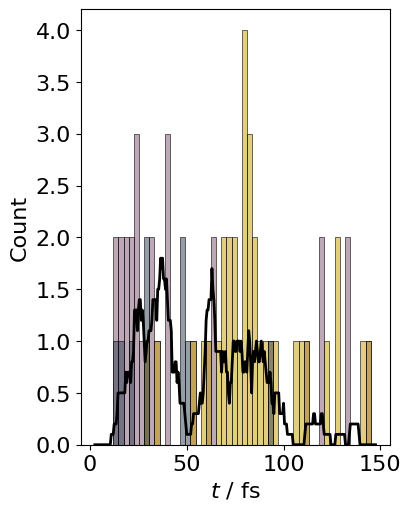

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', size=16)
plt.rc('lines', linewidth=2)
fig, ax = plt.subplots(1,1, layout='constrained')
fig.set_size_inches(4, 5)
sns.histplot(relevant.to_pandas(),palette=['#2c3e50', '#C4A000', '#7E5273'], bins=50, ax=ax, legend=False)
ax.set_xlabel("$t$ / fs")

# A rolling average of how many hops take place at each timestep
is_hop = (A03.astate.sh.sudi() != 0).groupby('time').sum()
# astype(float) avoids ill-fated attempts to cast NaN to int
rolling = is_hop.astype(float).rolling(time=10, center=True).mean()
ax.plot(rolling.time, rolling, c='k')
fig.savefig('/nc/reports/2025-06-30_4-step_figure/1.pdf')